# Dependencies

In [1]:
import json
from itertools import combinations, permutations

import networkx as nx
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm

clr = sns.color_palette("deep").as_hex()
clr

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

# Load the Map Data
Found by loading the official map on EUROSATORYs website, and using the network inspection tool in Firefox.

In [2]:
with open("map.json") as f:
    data = json.load(f)

# Create the Graph Representation
I'm using `networkx` for working with graphs in python.

In [3]:
node_pos = {i: (pos["x"], pos["y"]) for i, pos in enumerate(data["routing"]["nodes"])} # Extract the vertex xy-coordinates from the json
node_lbl = {i["n"]: i["a"] for i in data["routing"]["poiRoutingNodes"]} # Extract the predefined vertex labels from the json

nodes = [(i, {"pos": (x, y)}) for i, (x, y) in node_pos.items()] # List of vertex indices
edges = []
for e in data["routing"]["edges"]:
    v = e["s"]
    u = e["e"]
    v_pos = node_pos[v]
    u_pos = node_pos[u]
    dist = np.sqrt((v_pos[0] - u_pos[0])**2 + (v_pos[1] - u_pos[1])**2)
    edges.append((v, u, dist)) # List of edges with their lengths  
# edges = [(e["s"], e["e"], e["l"]) for e in data["routing"]["edges"] if e["l"] > 0] # List of edges with their lengths

In [4]:
G = nx.Graph() # Create a new graph
G.add_nodes_from(nodes) # Add the vertices to the graph
G.add_weighted_edges_from(edges) # Add the edges to the graph
G.remove_edges_from(nx.selfloop_edges(G)) # Remove self-loops

We need to specify which POIs we want to visit

In [5]:
tour = {"K144", "G210", "D179", "C79", "D243", "E115", "F115", "C190", "CD74", "D90", "G280"} # The tour in unspecified order
poi_pos = {lbl["poiID"]: (lbl["centerX"], lbl["centerY"]) for lbl in data["pois"]["labels"] if lbl["poiID"] in tour} # Extract the xy-coordinates of the tour from the json
poi_lbl = {"K144": "DI-FOS", "G210": "GMV", "D179": "MBDA", "C79": "Airbus", "D243": "Airbus", "E115": "Rheinmetall", "F115": "Rheinmetall", "C190": "Amonyx", "CD74": "Numalis", "D90": "KNDS", "G280": "Diehl Defence"} # The predefined labels of the tour
pois = [(i, {"pos": (x, y)}) for i, (x, y) in poi_pos.items()]

G.add_nodes_from(pois)

The *pois* are not connected to the rest of the graph, as they are missing edges. Consequently, we draw an edge between each *poi* and its spatially nearest vertex.

In [6]:
connections = []
for v, (x, y) in poi_pos.items():
    nn = None
    min_dist = float("inf")
    for u, (i, j) in node_pos.items():
        length = np.sqrt((x - i) ** 2 + (y - j) ** 2)
        if length < min_dist:
            min_dist = length
            nn = u
    connections.append((nn, v, min_dist))

G.add_weighted_edges_from(connections)

# Initial Visualization

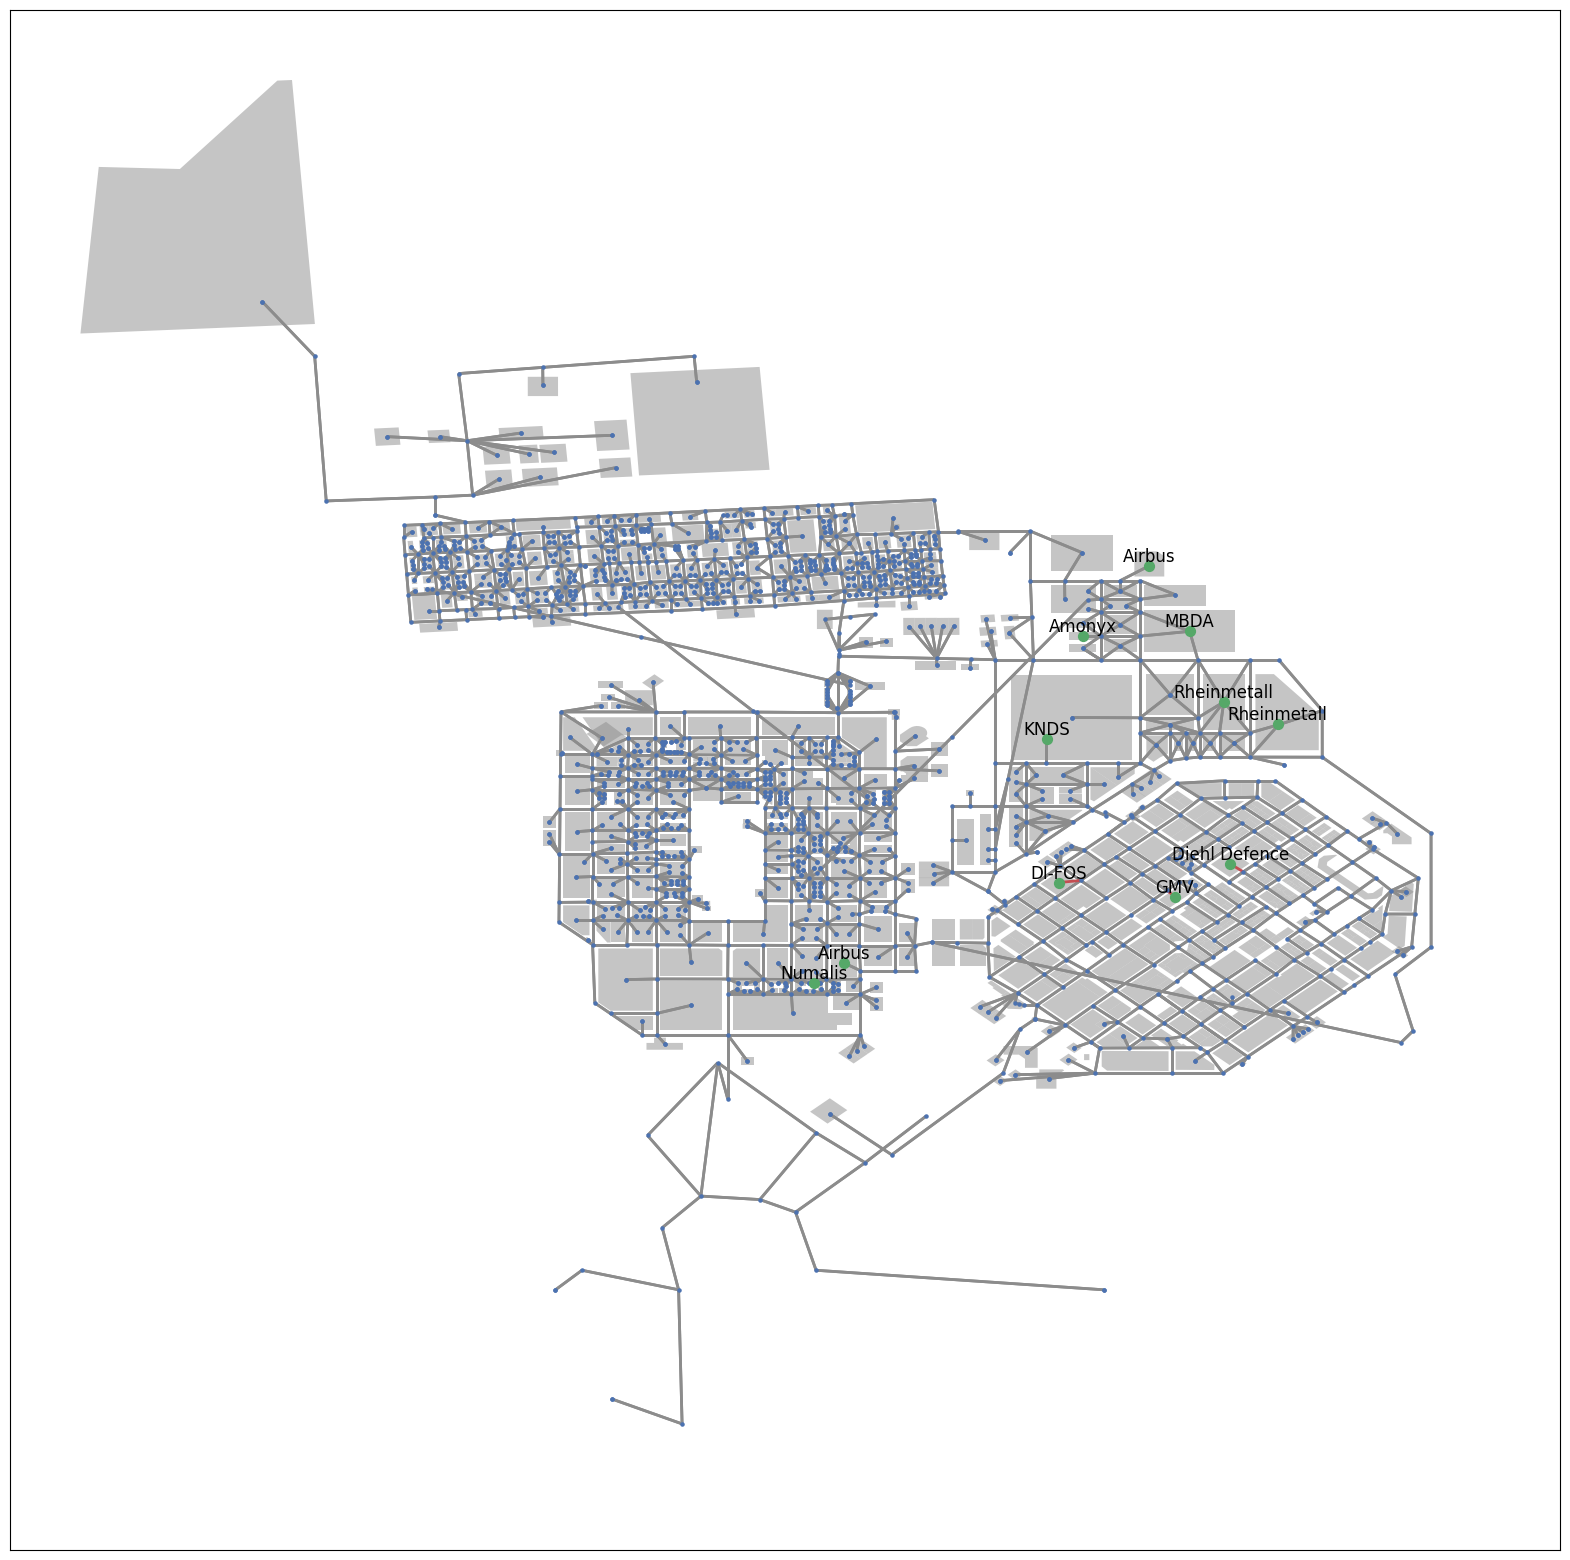

In [8]:
fig = plt.figure(figsize=(20, 20)) # Create a new figure
ax = fig.add_subplot(111) # Add a new subplot to the figure

# Structures: Draw the polygons for each "Point of Interest" defined in the json
for poly in data["pois"]["polygons"]:
    
    if poly["poiID"] in {"outside", "ext-taxi", "ext-distrib", "B5A", "B5B", "B6"}:
        continue

    points = [i.split(' ') for i in poly["points"].split(',')] # Extract the points of the polygon from the json
    points = list(map(lambda x: (float(x[0]), float(x[1])), points)) # Convert the points to floats
    ax.add_patch(Polygon(points, edgecolor='none', facecolor=clr[7], alpha=0.5))

# Graph: Draw the graph
nx.draw_networkx_nodes(G=G, pos=node_pos , nodelist=[n[0] for n in nodes], node_size=5, node_color=clr[0], ax=ax)
nx.draw_networkx_nodes(G=G, pos=poi_pos , nodelist=[n[0] for n in pois], node_size=50, node_color=clr[2], ax=ax)
nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=[(x,y) for x,y,_ in edges], width=2, edge_color=clr[7], ax=ax)
nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=[(x,y) for x,y,_ in connections], width=2, edge_color=clr[3], ax=ax)
nx.draw_networkx_labels(G=G, pos=poi_pos, labels=poi_lbl, verticalalignment="bottom", ax=ax)

fig.gca().invert_yaxis()

Interactive version

In [9]:
edge_x = []
edge_y = []
for x, y in G.edges():
    x0, y0 = G.nodes[x]['pos']
    x1, y1 = G.nodes[y]['pos']
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color=clr[7]),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}: ({x}, {y})")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text = node_text,
    marker=dict(
        color=clr[0],
        size=10,
        line_width=1))

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='EUROSATORY MAP',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                )
fig.write_html("map.html", config=dict(scrollZoom=True))

# A*
Though we could use the built-in function `nx.astar_path`, it is much more fun to see what is actually happening in code. We therefore manually define the A* path-finding algorithm:

In [10]:
def a_star(start: str | int, goal: str | int):

    def h(a, b):
        (x1, y1) = G.nodes[a]["pos"]
        (x2, y2) = G.nodes[b]["pos"]
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: h(start, goal)}

    while open_set:
        current = min(open_set, key=lambda n: f_score[n])

        if current == goal:
            path = [current]
            length = g_score[current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], length

        open_set.remove(current)

        for neighbor in G[current]:
            tentative_g_score = g_score[current] + G[current][neighbor]["weight"]
            if tentative_g_score < g_score.get(neighbor, float("inf")):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + h(neighbor, goal)
                open_set.add(neighbor)

    raise Exception("No path found")

We use A* to break down the combinatorial problem to something more manageable. We start by finding the quickest path between any pair of *pois*.

In [11]:
pairs = {}
i = 0
for a, b in combinations(tour, 2):
    pairs.setdefault(a, {})
    pairs.setdefault(b, {})
    pairs[a][b] = pairs[b][a] = a_star(a, b)[1]
    i += 1
print(f"Pairs: {i}")

Pairs: 55


We now start the combinatorial problem. As long as the tour is not too long, we can simply brute-force our way through!

In [17]:
v_start = "K144"
path_length = float("inf")
path_shortest = []
path_options = list(permutations(tour - {v_start}))
for path in tqdm(path_options):
    length = 0
    path = [v_start] + list(path)
    for i in range(len(path) - 1):
        length += pairs[path[i]][path[i + 1]]
    if length < path_length:
        path_length = length
        path_shortest = path
# print(f"Optimal Paths is ({path_length:.2f}): {path_shortest}")
print(f"Optimal Paths is ({path_length:.2f}): {[poi_lbl[i] for i in path_shortest]}")

  0%|          | 0/3628800 [00:00<?, ?it/s]

Optimal Paths is (1838.74): ['DI-FOS', 'GMV', 'Diehl Defence', 'Rheinmetall', 'Rheinmetall', 'MBDA', 'Airbus', 'Amonyx', 'KNDS', 'Airbus', 'Numalis']


Let's plot this!

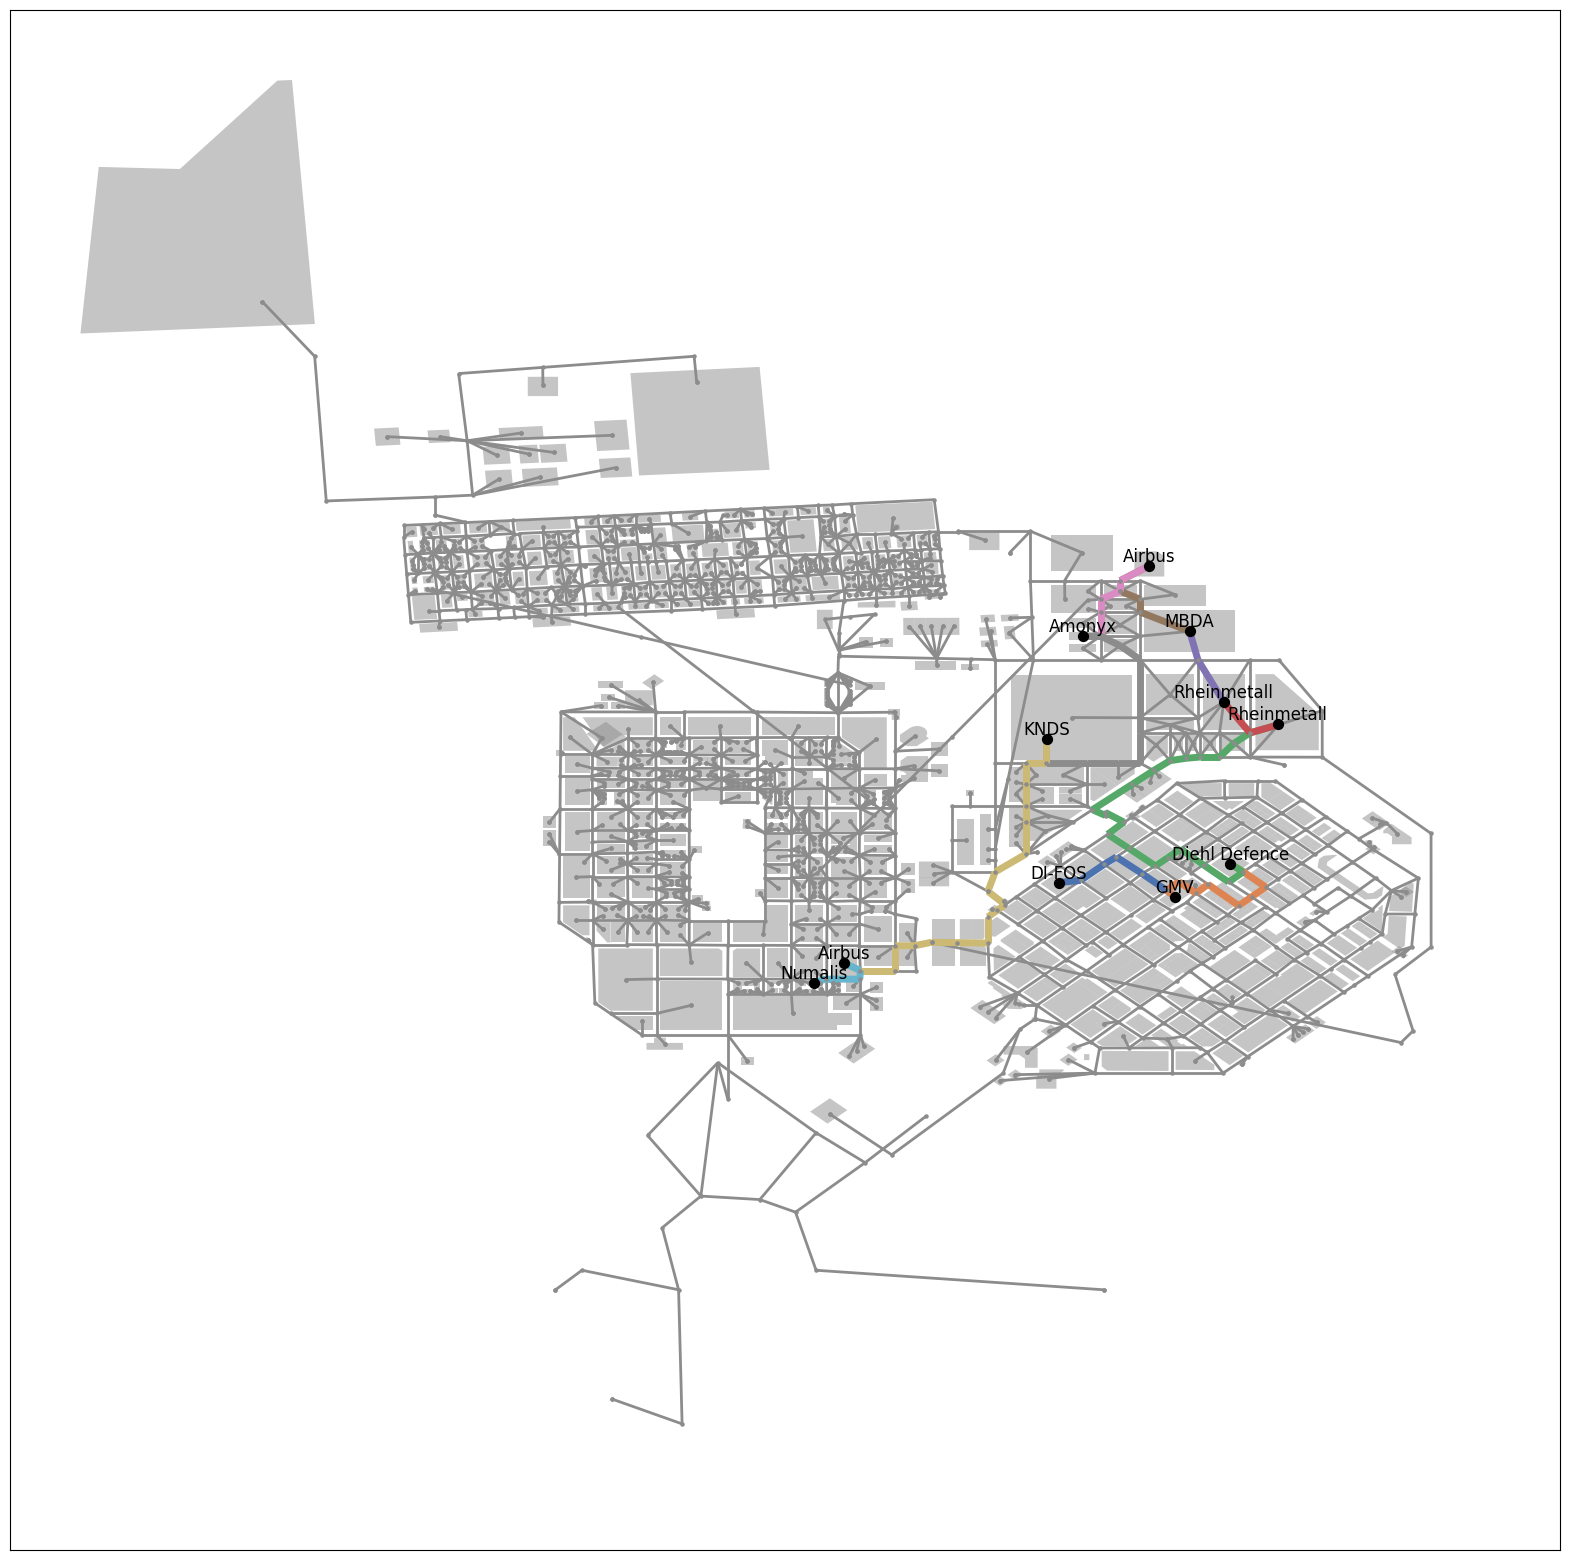

In [21]:
fig = plt.figure(figsize=(20, 20)) # Create a new figure
ax = fig.add_subplot(111) # Add a new subplot to the figure

# Structures: Draw the polygons for each "Point of Interest" defined in the json
for poly in data["pois"]["polygons"]:
    
    if poly["poiID"] in {"outside", "ext-taxi", "ext-distrib", "B5A", "B5B", "B6"}:
        continue

    points = [i.split(' ') for i in poly["points"].split(',')] # Extract the points of the polygon from the json
    points = list(map(lambda x: (float(x[0]), float(x[1])), points)) # Convert the points to floats
    ax.add_patch(Polygon(points, edgecolor='none', facecolor=clr[7], alpha=0.5))

# Graph: Draw the graph
nx.draw_networkx_nodes(G=G, pos=node_pos , nodelist=[n[0] for n in nodes], node_size=5, node_color=clr[7], ax=ax)
nx.draw_networkx_nodes(G=G, pos=poi_pos , nodelist=[n[0] for n in pois], node_size=50, node_color="black", ax=ax)
nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=G.edges, width=2, edge_color=clr[7], ax=ax)
nx.draw_networkx_labels(G=G, pos=poi_pos, labels=poi_lbl, verticalalignment="bottom", ax=ax)

# Map the path back to the graph
for color, (i, j) in enumerate(zip(path_shortest[:-1], path_shortest[1:])):
    path_graph = a_star(i, j)[0]
    nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=list(zip(path_graph[:-1], path_graph[1:])), width=5, edge_color=clr[color],alpha=1, ax=ax)

fig.gca().invert_yaxis()

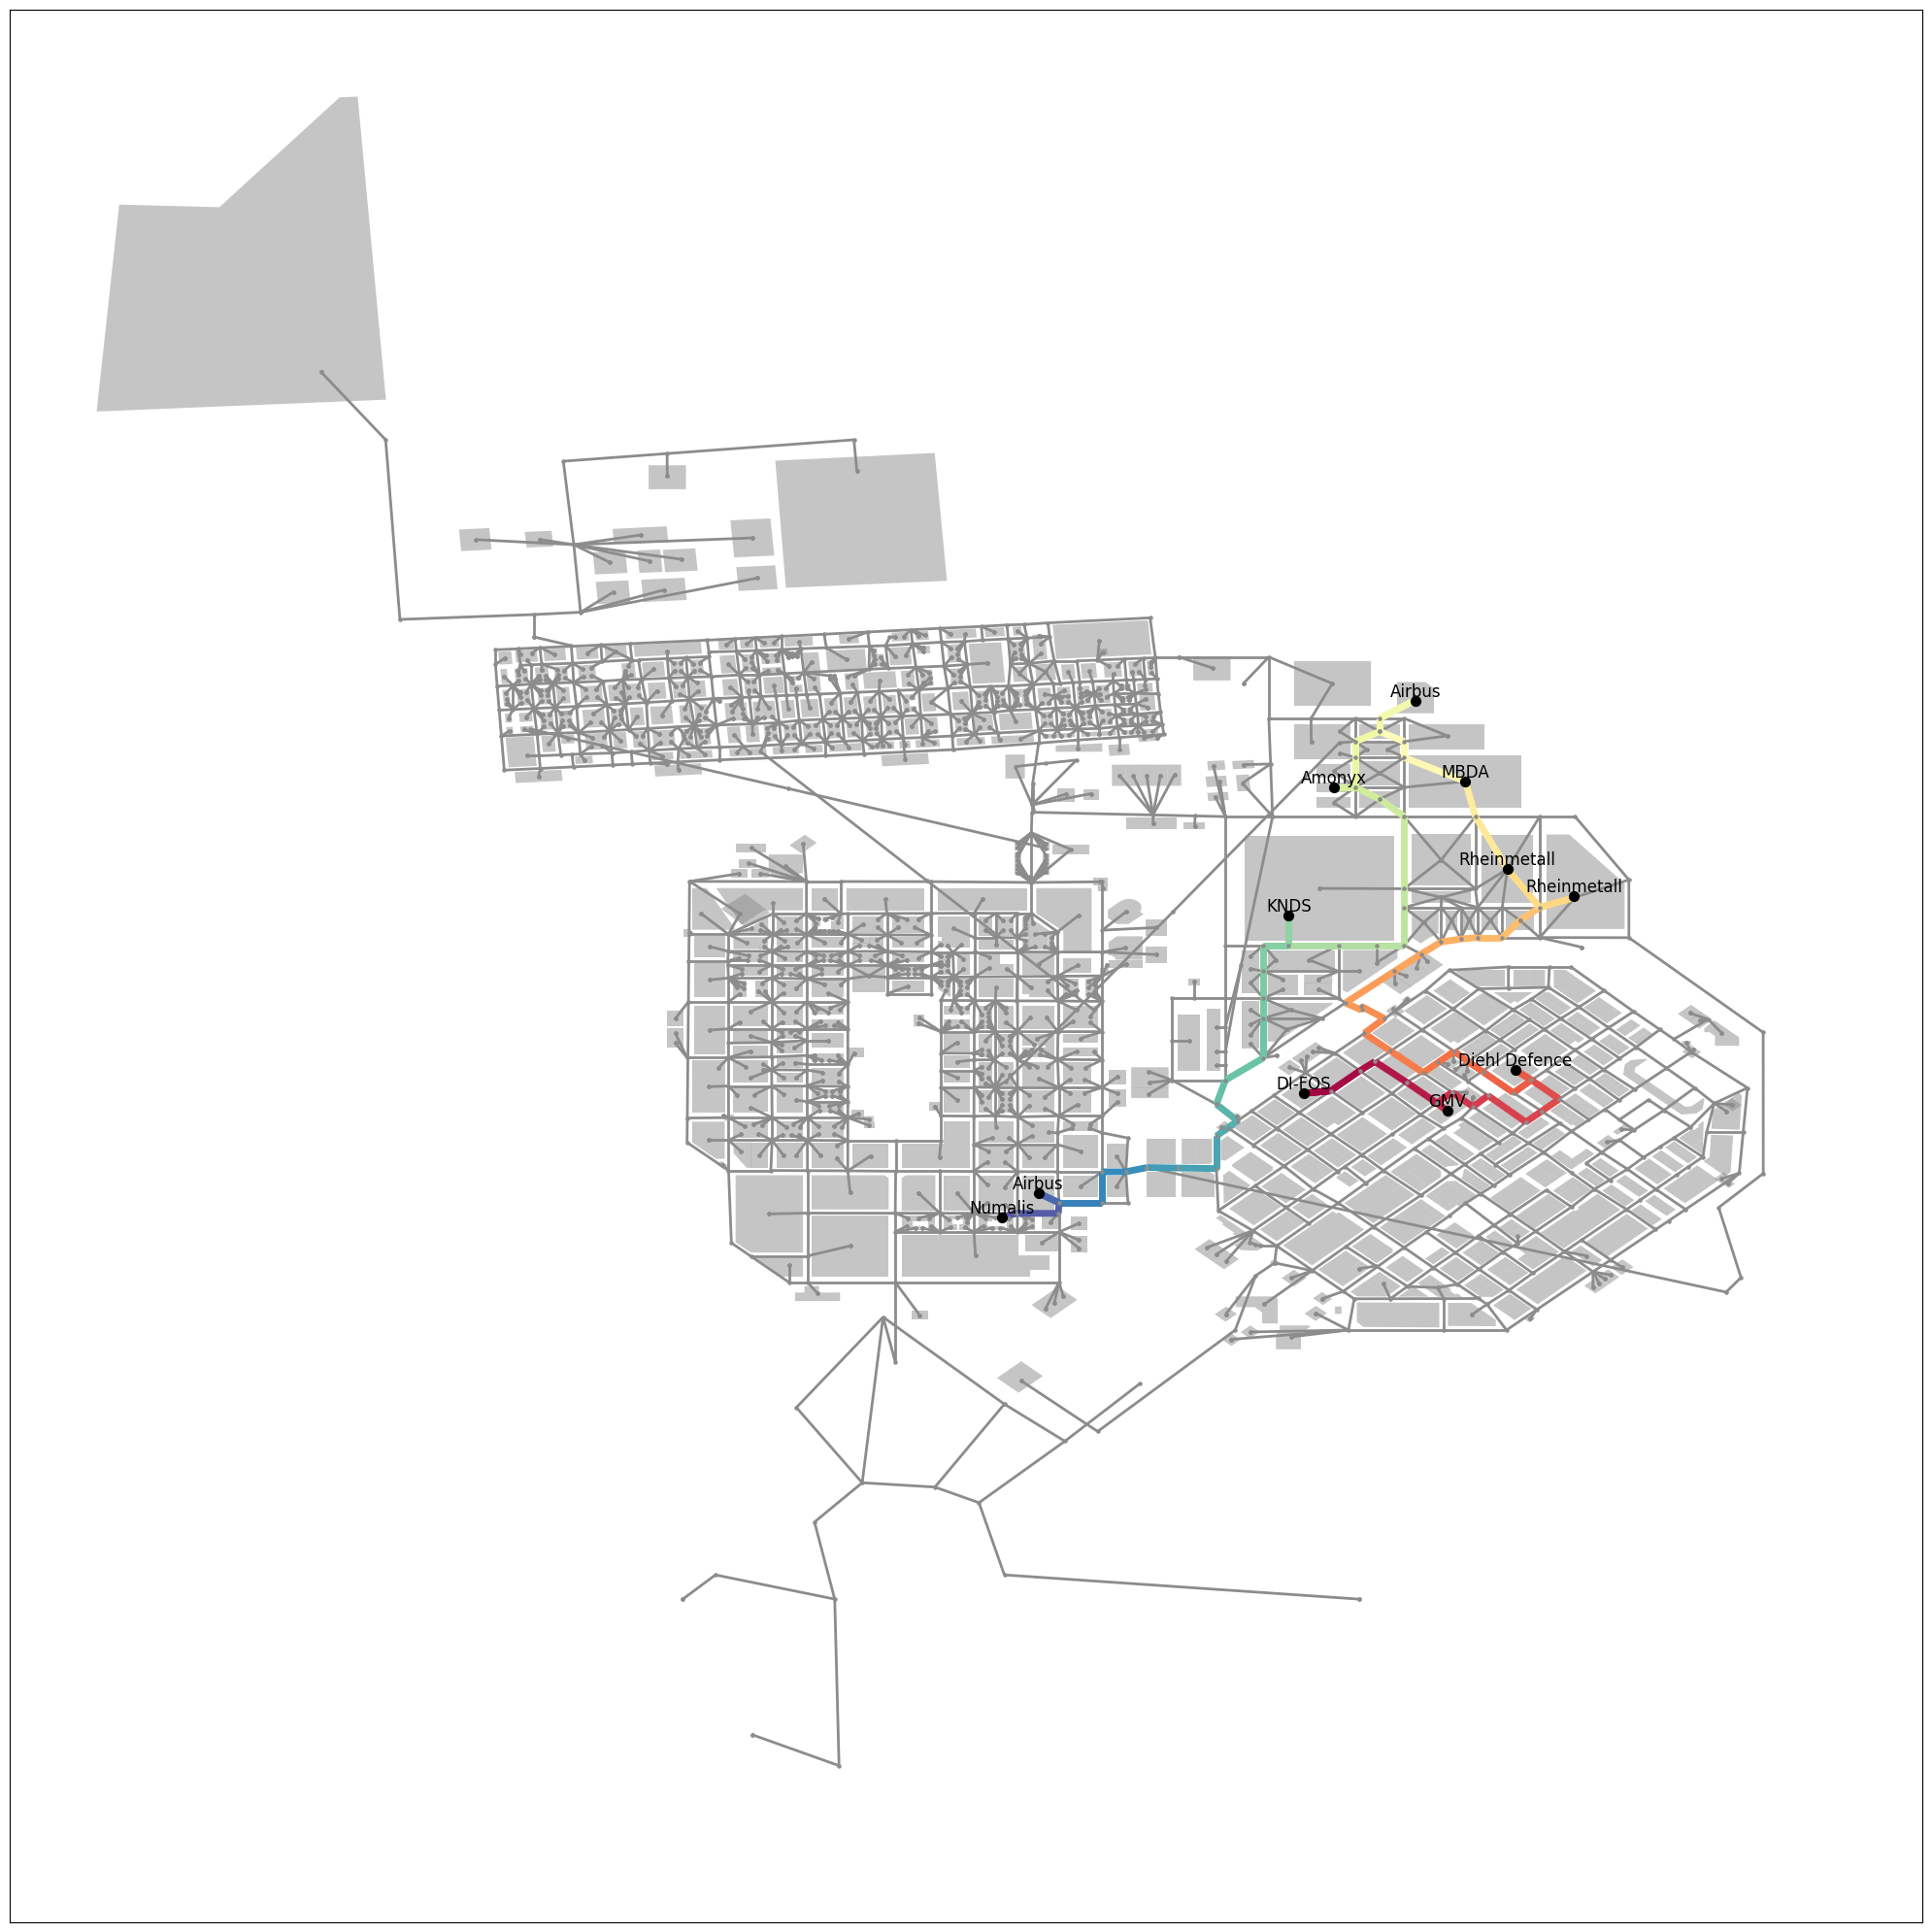

In [22]:
fig = plt.figure(figsize=(20, 20)) # Create a new figure
ax = fig.add_subplot(111) # Add a new subplot to the figure

# Structures: Draw the polygons for each "Point of Interest" defined in the json
for poly in data["pois"]["polygons"]:
    
    if poly["poiID"] in {"outside", "ext-taxi", "ext-distrib", "B5A", "B5B", "B6"}:
        continue

    points = [i.split(' ') for i in poly["points"].split(',')] # Extract the points of the polygon from the json
    points = list(map(lambda x: (float(x[0]), float(x[1])), points)) # Convert the points to floats
    ax.add_patch(Polygon(points, edgecolor='none', facecolor=clr[7], alpha=0.5))

# Graph: Draw the graph
nx.draw_networkx_nodes(G=G, pos=node_pos , nodelist=[n[0] for n in nodes], node_size=5, node_color=clr[7], ax=ax)
nx.draw_networkx_nodes(G=G, pos=poi_pos , nodelist=[n[0] for n in pois], node_size=50, node_color="black", ax=ax)
nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=G.edges, width=2, edge_color=clr[7], ax=ax)
nx.draw_networkx_labels(G=G, pos=poi_pos, labels=poi_lbl, verticalalignment="bottom", ax=ax)

fig.tight_layout()
fig.gca().invert_yaxis()

path_graph = []
for v, u in zip(path_shortest[:-1], path_shortest[1:]):
    path_graph += a_star(v, u)[0]
path_graph_edges = list(zip(path_graph[:-1], path_graph[1:]))
colors = sns.color_palette("Spectral", n_colors=len(path_graph_edges)).as_hex()

def update(frame):
    nx.draw_networkx_edges(G=G, pos=node_pos | poi_pos, edgelist=[path_graph_edges[frame]], width=5, edge_color=colors[frame], ax=ax)

ani = FuncAnimation(fig, update, frames=len(path_graph_edges)-1)
ani.save('path.gif', writer='pillow', fps=10)